In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline


In [23]:
file_name = 'crypto_data_2.csv'
df = pd.read_csv(file_name)
print(len(df))
# print(df)

#df['date'] = pd.to_datetime(df['date'])

df.drop(columns=['formatted_date'], inplace=True)

df.index = range(len(df))


df.dropna(inplace=True)
print(len(df))
df.reset_index(drop=True)

df.isnull().values.any()
df

22545
22545


,date,high,low,open,close,volume,adjclose,coin
0,1483228800,1003.080017,958.698975,963.658020,0.965275,147775008.0,998.325012,BTC-USD
1,1483315200,1031.390015,996.702026,998.617004,0.977359,222184992.0,1021.750000,BTC-USD
2,1483401600,1044.079956,1021.599976,1021.599976,0.978694,185168000.0,1043.839966,BTC-USD
3,1483488000,1159.420044,1044.400024,1044.400024,0.904454,344945984.0,1154.729980,BTC-USD
4,1483574400,1191.099976,910.416992,1156.729980,1.141457,510199008.0,1013.380005,BTC-USD
...,...,...,...,...,...,...,...,...
22540,1637280000,0.599902,0.578802,0.587495,0.981075,18297714.0,0.598828,STEEM-USD
22541,1637366400,0.629454,0.592715,0.598567,0.962636,24017942.0,0.621800,STEEM-USD
22542,1637452800,0.636343,0.612385,0.622577,1.016643,20991912.0,0.612385,STEEM-USD
22543,1637539200,0.616244,0.586800,0.611114,1.035923,21138903.0,0.589922,STEEM-USD


In [24]:

df['SMA_14'] = df['close'].rolling(14).mean().shift()
df['SMA_30'] = df['close'].rolling(20).mean().shift()
df['SMA_50'] = df['close'].rolling(50).mean().shift()
df['SMA_200'] = df['close'].rolling(200).mean().shift()



def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI_14'] = relative_strength_idx(df, 14).fillna(0)
df['RSI_30'] = relative_strength_idx(df, 30).fillna(0)
df['RSI_50'] = relative_strength_idx(df, 50).fillna(0)
df['RSI_200'] = relative_strength_idx(df, 200).fillna(0)

df.dropna(inplace=True)
df.isnull().values.any()



False

In [25]:
test_size  = 0.15
valid_size = 0.15


test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()



In [27]:
drop_cols = ['date', 'volume', 'open', 'low', 'high', 'adjclose', 'coin']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

test_df['close'].values

test_df.head()

<ipython-input-27-fbc530f1f6be>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_df = train_df.drop(drop_cols, 1)
<ipython-input-27-fbc530f1f6be>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  valid_df = valid_df.drop(drop_cols, 1)
<ipython-input-27-fbc530f1f6be>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_df  = test_df.drop(drop_cols, 1)


,close,SMA_14,SMA_30,SMA_50,SMA_200,RSI_14,RSI_30,RSI_50,RSI_200
18994,0.994694,0.988680,0.991458,0.997399,1.002648,55.120969,49.700799,50.348977,50.107496
18995,0.980095,0.995651,0.990617,0.997776,1.002800,43.465585,48.904010,50.419954,50.130631
18996,1.023308,0.988349,0.992081,0.998229,1.002986,45.323731,50.826099,49.746412,49.930806
18997,0.986650,0.982946,0.992157,0.997959,1.002888,48.424965,49.734887,49.845169,49.546458
18998,0.987586,0.981243,0.990245,0.997795,1.002249,50.911394,49.985853,49.516593,49.736690


In [28]:
y_train = train_df['close'].copy().values
X_train = train_df.drop(['close'], 1).values

y_valid = valid_df['close'].copy().values
X_valid = valid_df.drop(['close'], 1).values

print(test_df['close'])
y_test  = test_df['close'].copy().values
X_test  = test_df.drop(['close'], 1).values

mean = y_train.mean()
sd = y_train.std()
y_train = (y_train - mean)/sd
y_valid = (y_valid - mean)/sd
y_test = (y_test - mean)/sd
print(y_test )

18994    0.994694
18995    0.980095
18996    1.023308
18997    0.986650
18998    0.987586
           ...   
22540    0.981075
22541    0.962636
22542    1.016643
22543    1.035923
22544    0.946083
Name: close, Length: 3551, dtype: float64
[-0.06184639 -0.27629122  0.35850667 ...  0.26059347  0.54381937
 -0.77594024]


<ipython-input-28-bfd8939be789>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train_df.drop(['close'], 1).values
<ipython-input-28-bfd8939be789>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_valid = valid_df.drop(['close'], 1).values
<ipython-input-28-bfd8939be789>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test  = test_df.drop(['close'], 1).values


In [29]:
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()


for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])


0.6360433966320848 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


In [30]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)



In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.43915531136847047
Mean Squared Error: 0.43897470351369333
Root Mean Squared Error: 0.6625516610149682


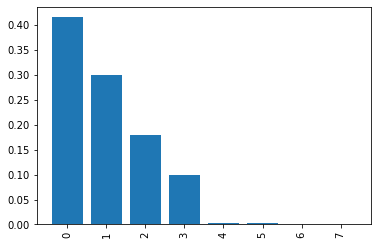

In [32]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))

plt.bar(x_values, importances[sorted_index])
plt.xticks(rotation=90)
plt.show()